# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 2:  $k$-NN and Linear Regression 

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [10]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [11]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

# <div class="theme"> Predicting Taxi Pickups in NYC </div>

In this homework, we will explore $k$-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York City at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

## <div class="exercise"> <b> Question 1  [13 pts]</b> </div>

**1.1 [2 pts]**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2 [3 pts]**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.

**1.3 [4 pts]**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4 [4 pts]**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.


### Answers

**1.1 [2 pts]. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.**

In [12]:
# read the file
cab_df = pd.read_csv("data/nyc_taxi.csv")
cab_df.head()

,TimeMin,PickupCount,Day
0,860,33,Fri
1,17,75,Sun
2,486,13,Sun
3,300,5,Thu
4,385,10,Thu


In [13]:
# split the data
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=109)
train_data.head()

,TimeMin,PickupCount,Day
346,749,32,Wed
1027,244,9,Fri
126,745,19,Mon
814,1177,54,Mon
908,833,43,Thu


**1.2 [3 pts]. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.**

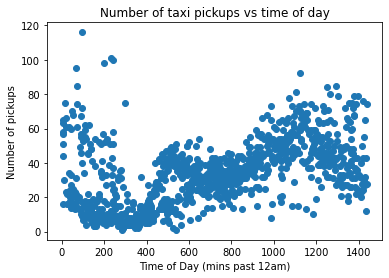

In [14]:
X_train = train_data[['TimeMin']]
y_train = train_data['PickupCount']

X_test = test_data[['TimeMin']]
y_test = test_data[['PickupCount']]

plt.scatter(X_train, y_train)
plt.xlabel('Time of Day (mins past 12am)')
plt.ylabel('Number of pickups')
plt.title('Number of taxi pickups vs time of day');


**1.3 [4 pts]. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**



We see a S-shaped curve over the course of the day with the pickups lowest around the 200-400min range (3:20am - 6:40am). Not many people are out and about during this time so the lull makes sense. The pickup count slowly picks up to reach its peak at around 7-9pm. Since the time is continuous, it makes sense that the graph looks like it can wrap around to the beginning without there being a sharp changed (the pickup rate is roughly the same during 11pm-12am as it is from 12am-1am thus showing no break in continuity).

**1.4 [4 pts]. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.**

This is peak office hour for people trying to reach their offices by the traditional 9am start time during the weekdays. There is a stark difference between the number of pickups on the weekend as compared to weekdays which is causing the hole.


In [15]:
print("Pickups on the weekend")
display(train_data[(train_data.TimeMin < 550) & (train_data.TimeMin > 500) & ((train_data.Day == 'Sun') | (train_data.Day == 'Sat'))].head())
print("Pickups on weekdays")
train_data[(train_data.TimeMin < 550) & (train_data.TimeMin > 500) & (train_data.Day != 'Sun') & (train_data.Day != 'Sat')].head()


Pickups on the weekend


,TimeMin,PickupCount,Day
281,525,2,Sun
227,511,17,Sun
956,532,13,Sun
189,504,5,Sat
76,511,15,Sun


Pickups on weekdays


,TimeMin,PickupCount,Day
419,506,47,Wed
681,515,49,Wed
949,530,41,Thu
532,543,38,Mon
233,507,41,Fri


## <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen $k$-Nearest Neighbors ($k$-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run $k$-NN Regression. 


**2.1 [4 pts]**. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2 [6 pts]**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3 [3 pts]**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4 [3 pts]**. Plot, in a single figure, the two 'curves' of $R^2$ values from the models on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5 [9 pts]**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

### Answers

**2.1 [4 pts]. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`).**


In [16]:
# Dictionary of different regressors
knndict = {}

# List of different k-values
k_list = [1,10,75,250,500,750,1000]

# Do a bunch of KNN regressions
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(X_train, y_train)
    # Store the regressors in a dictionary
    knndict[k] = knnreg 

# Print the dictionary to see what we have
knndict


{1: KNeighborsRegressor(n_neighbors=1),
 10: KNeighborsRegressor(n_neighbors=10),
 75: KNeighborsRegressor(n_neighbors=75),
 250: KNeighborsRegressor(n_neighbors=250),
 500: KNeighborsRegressor(n_neighbors=500),
 750: KNeighborsRegressor(n_neighbors=750),
 1000: KNeighborsRegressor(n_neighbors=1000)}


**2.2 [5 pts].  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a line plot of predictions for `PickupCount` vs  a dummy `TimeMin` using `np.arange(np.min(train['TimeMin']),np.max(train['TimeMin']),1)`.  Do the same for the test set in separate plots.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set.** 

**Hints**:
1. Each subplot should use different color to distinguish k-NN regression prediction curve from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  

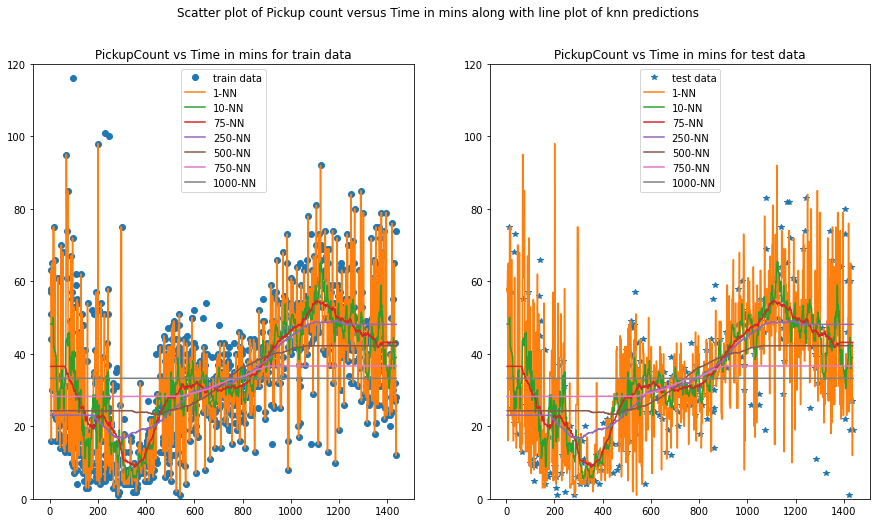

In [18]:
xgrid = np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1).reshape(-1,1)

# unpack the dictionary to its elements (items) which is the k and Regressor
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(X_train, y_train, 'o', label="train data")
ax[1].plot(X_test, y_test, '*', label="test data")
for k, model in knndict.items():
    predictions = model.predict(xgrid) 
    ax[0].plot(xgrid, predictions, label="{}-NN".format(k))
    ax[1].plot(xgrid, predictions, label="{}-NN".format(k))
   
ax[0].set_title('PickupCount vs Time in mins for train data')
ax[1].set_title('PickupCount vs Time in mins for test data')

# set limits so that both plots are on the same scale
ax[0].set_ylim(0, 120)
ax[1].set_ylim(0, 120)

ax[0].legend();
ax[1].legend();
plt.suptitle('Scatter plot of Pickup count versus Time in mins along with line plot of knn predictions');

# OKAY, IK THIS IS WRONG BUT I KNOW WHAT I DID WRONG AND IT'S EASY TO FIX

In [ ]:
# Plot predictions vs actual
# your code here 



**2.3 [3 pts]. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**



In [19]:
# your code here
r_squared_list = []

for k in k_list:
    r_squared_dict = {'k':k,'Training data': knndict[k].score(X_train, y_train), 'Test data': knndict[k].score(X_test, y_test)}
    r_squared_list.append(r_squared_dict)

pd.DataFrame(r_squared_list, columns = ['k','Training data','Test data'])

,k,Training data,Test data
0,1,0.667533,-0.074464
1,10,0.469673,0.414593
2,75,0.418806,0.479658
3,250,0.343803,0.394991
4,500,0.276392,0.302357
5,750,0.169987,0.179605
6,1000,0.000000,-0.000032


**2.4 [3 pts]. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.



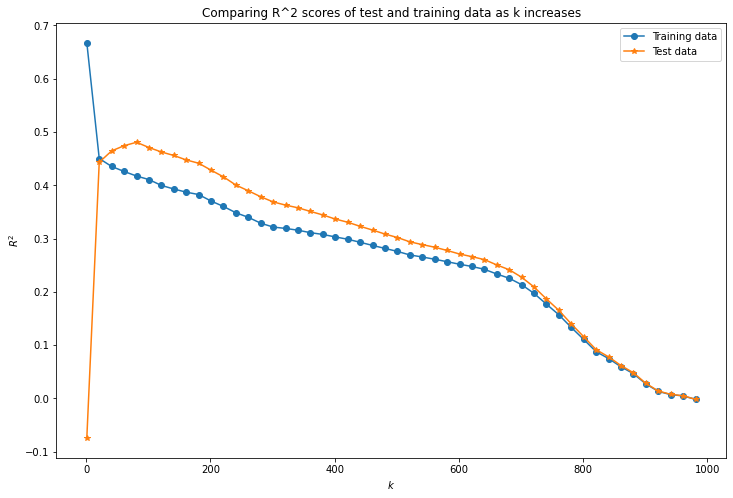

In [20]:
# your code here
ks = range(1, 1000, 20) # Grid of k's
scores_train = [] # R2 scores for training data
scores_test = [] # R2 scores for testing data
for k in ks:
    # Create KNN model
    knnreg = KNeighborsRegressor(n_neighbors=k) 
    
    # Fit the model to training data
    knnreg.fit(X_train, y_train) 
    
    # Calculate R^2 score for training data
    score_train = knnreg.score(X_train, y_train) 
    scores_train.append(score_train)
    
    # Calculate R^2 score for test data
    score_test = knnreg.score(X_test, y_test) 
    scores_test.append(score_test)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(ks, scores_train,'o-',label='Training data')
ax.plot(ks, scores_test,'*-', label='Test data')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')
ax.legend()
plt.title('Comparing R^2 scores of test and training data as k increases');


**2.5 [9 pts]. Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

It just takes the average of the whole dataset and uses that to predict new values.

2. What does an $R^2$ score of $0$ mean?  

The model performs equally to a model predicting based on the average of all values.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

It's worse than the model predicting based on the average. Yes $R^2$ was negative for $k=1,1000$ for the `test_data`.

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

Yes, the training data has a continuous downwards trend. The test data has a hill shaped curve where it increases to a peak and then follows a path similar to that of the training data.

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

The best value of $k$ is around 80. We chose this value based on the highest $R^2$ value in the `test_data`. The $R^2$ value of the `test_data` for $k=80$ is much higher than the $R^2$ for the `train_data` (nearly 0.5 compared to roughly 0.41).

6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

The mean squared error would show an upward trend in the case of the `train_data` while there would be a valley for the `test_data`. So in a way flipping the $R^2$ graphs vertically would give us a rough idea of how the MSE plot would look like!

## <div class="exercise"> <b> Question 3 [23 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1 [3 pts]**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2 [3 pts]**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4 [2 pts]**. Report the estimates for the slope and intercept for the fitted linear model.

**3.5 [3 pts]**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6 [10 pts]**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers



**3.1 [3 pts]. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.**



In [21]:
# your code here
X = sm.add_constant(X_train)
lin_reg_sm = sm.OLS(y_train, X)
OLSModel = lin_reg_sm.fit()

/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**3.2 [3 pts]. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.**

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  



ValueError: shapes (1434,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

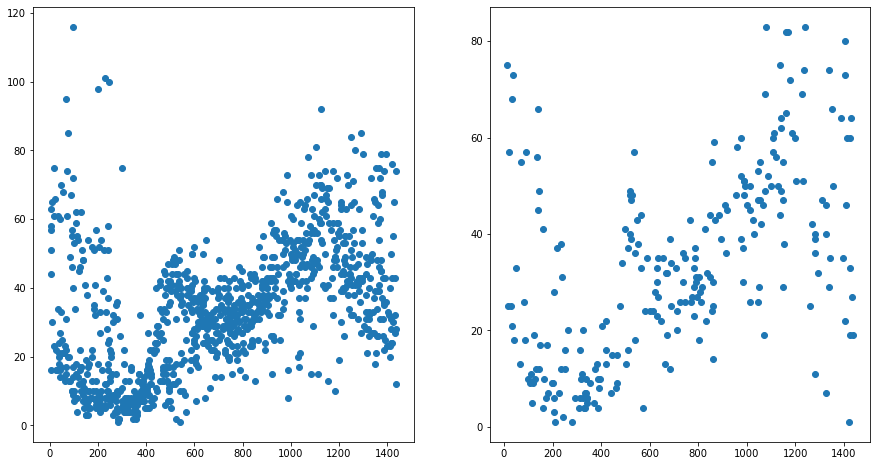

In [32]:
# your code here
xgrid = np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1).reshape(-1,1)

# unpack the dictionary to its elements (items) which is the k and Regressor
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(X_train, y_train, 'o', label="train data")
ax[1].plot(X_test, y_test, 'o', label="test data")
   
predictions = OLSModel.predict(xgrid)
ax[0].plot(xgrid, predictions, '*', label="predicted data")
ax[1].plot(xgrid, predictions, '*', label="predicted data")

ax[0].set_title('PickupCount vs Time in mins for train data')
ax[1].set_title('PickupCount vs Time in mins for test data')

# set limits so that both plots are on the same scale
ax[0].set_ylim(0, 120)
ax[1].set_ylim(0, 120)

ax[0].legend();
ax[1].legend();
plt.suptitle('Scatter plot of Pickup count versus Time in mins along with line plot of knn predictions');

In [ ]:
# your code here 


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.



In [ ]:
# your code here


**3.4 [2 pts]. Report the estimates for the slope and intercept for the fitted linear model.**



In [34]:
# your code here
beta0_sm = OLSModel.params[0]
beta1_sm = OLSModel.params[1]

print(f'The regression coef from statsmodels are: beta_0 = {beta0_sm:8.6f} and beta_1 = {beta1_sm:8.6f}')

The regression coef from statsmodels are: beta_0 = 17.341910 and beta_1 = 0.022715


**3.5 [3 pts]. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 



In [ ]:
# your code here



**3.6 [10 pts]. Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

*your answer here*

2. What does the sign of the slope of the fitted linear model convey about the data?  

*your answer here*

3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 

*your answer here*

4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  

*your answer here*

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

*your answer here*


## <div class="exercise"> <b> Question 4 [12 pts] </b></div>

We next consider investigating how the day of the week is associated with pickups to improve both the predictive accuracy of the models and help with more in depth interpretations.  We begin by using the non-parametric *k*-NN approach.   

**4.1 [2 pts]**. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday. 

**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.

**4.3 [3 pts]**. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot). 

**4.4 [4 pts]**. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.






### Answers


**4.1 [2 pts]. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday.** 



In [35]:
# your code here
train_data["Weekend"] = 1 * ((train_data['Day'] == "Sat") | (train_data["Day"] == "Sun"))
train_data.head()


test_data["Weekend"] = 1 * ((test_data['Day'] == "Sat") | (test_data["Day"] == "Sun"))
test_data.head()

,TimeMin,PickupCount,Day,Weekend
1052,486,34,Mon,0
916,420,13,Sat,1
284,1138,75,Sat,1
176,645,22,Thu,0
219,1140,62,Fri,0


**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.


In [67]:
knnreg80 = KNeighborsRegressor(n_neighbors=80)
X = train_data["Weekend"] * 1600 + train_data["TimeMin"]

knnreg80.fit(np.array(X).reshape(-1,1), train_data['PickupCount'])

KNeighborsRegressor(n_neighbors=80)

**4.3 [3 pts]. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot).**


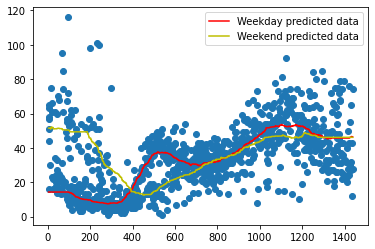

In [74]:
# your code here
plt.scatter(X_train, y_train)
predictions_weekdays = knnreg80.predict(xgrid)
predictions_weekends = knnreg80.predict(xgrid + 1600)
plt.plot(xgrid, predictions_weekdays, label="Weekday predicted data", c='r');
plt.plot(xgrid, predictions_weekends, label="Weekend predicted data", c='y');
plt.legend();


**4.4 [4 pts]. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.**


On one hand, for weekends, there is generally a dip between midnight and 10am before increasing a bit and plateauing. On the other hand, for weekdays, there is much more fluctuation. While following a general pattern of the weekends, it has peaks at 9am and 5pm (which are rush hours), so the trends make sense.
Also, it might be reasonable to assume that people usually go out on weekends (to parties, etc) and thus the cab pick up rate in the wee hours is higher than it is for weekdays. The weekend curve has a sluggish upwards trend towards early morning maybe because most people stay in.

##### <div class="exercise"> <b> Question 5 [27 pts] </b></div>

Finally we turn to multiple regression models to see if there is a weekend affect.  Note: Use sklearn to do the modeling unless otherwise stated.


**5.1 [6 pts]**. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.

**5.2 [6 pts]**. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.

**5.3 [3 pts]**. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.

**5.4 [4 pts]**. Determine if the model in 5.3 is a more accurate model than the *k*-NN model in 4.2.  Why do you suppose this is the case?

**5.5 [5 pts]**. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot of the training data). How does this compare to the plot from 4.3?

**5.6 [3 pts]**. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.

### Answers

**5.1 [6 pts]. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:**

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.


In [81]:
# your code here
X = sm.tools.add_constant(train_data[['TimeMin','Weekend']])
sm_multi_reg = sm.OLS(train_data['PickupCount'],X).fit()
sm_multi_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     164.4
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           1.93e-62
Time:                        08:25:31   Log-Likelihood:                -4216.4
No. Observations:                1000   AIC:                             8439.
Df Residuals:                     997   BIC:                             8454.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7475      1.107     14.220      0.000      13.574      17.921
TimeMin        0.0228      0.001     17.665      0.000       0.020       0.025
Weekend        4.6383      1.098      4.223      0.000       2.483       6.793
==============================================================================
Omnibus:                      183.150   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.494
Skew:                           1.008   Prob(JB):                     1.63e-90
Kurtosis:                       5.421   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*your answer here*


**5.2 [6 pts]. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.**



In [ ]:
# your code here

**5.3 [3 pts]. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.**


In [ ]:
# your code here


**5.4 [4 pts]. Determine if the model in 5.3 is a more predictive model than the *k*-NN model in 4.2.  Why do you suppose this is the case?**



In [ ]:
# your code here

*your answer here*

**5.5 [5 pts]. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot). How does this compare to the plot from 4.3?**



In [ ]:
# your code here

*your answer here*

**5.6 [3 pts]. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.**

*your answer here*